<a href="https://colab.research.google.com/github/Zypperman/DBTT_G1_GRP3/blob/main/Notebooks/Usecase_1_1_V1(OtherModels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use Case 1.1: Intermediate Loan Default Risk Prediction (LDRP)

- Now that we have a basic model to work with, we will now proceed to explore the different kinds of models that can be used and whether they can provide us with more robust results.  
  
  We will be using:

1. A Random Forest (RF) model  (sci-kit learn implemented as `RandomForestClassifier`)
2. A gradient boosted decision tree model, from the XGBoost Library (a variant of the scki-kit implemented model `GradientBoostingClassifier` but produced by Nvidia)
3. A K nearest neighbours classifier (sci-kit learn implemented as `KNeighborsClassifier`, where we will use `RandomSearchCV` to find an optimal k)
4. A Support Vector Machine Classifier (sci-kit learn implemented as `SVC`)
4. A mixture of experts model, using code adapted from [this kaggle demo notebook by a user named "Newton Baba"](https://www.kaggle.com/code/newtonbaba12345/mixture-of-experts-moe-explained#Implementation-of-MoE)
4. Kolmogorov-Arnold Networks (KANs), with a specific schema for credit default prediction named KACDP for high interpretability, obtained from a paper.However for ease of implementation, we will be referring to [this kaggle demo notebook by a user named "Rashid rk"](https://www.kaggle.com/code/rashidrk/exploring-kans-v2-0-14887-lb). The paper indicates that this model will yield significant results, and [can be found here](https://arxiv.org/pdf/2411.17783). The data utilized for this paper is the GMSC (Give Me Some Credit) dataset, consisting of 223k records. However, the variables in question seem very reminiscent of the HMEQ dataset, hence we will be reusing the HMEQ data since we are only featuring how these models can be trained and implemented, as opposed to creating an entire production-grade model.

In [ ]:
# import the relevant packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import *
from sklearn.base import clone
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

import statsmodels.api as sm
from scipy.stats import probplot
from sklearn import metrics
from sklearn import preprocessing
from sklearn import utils
from sklearn.metrics import mean_absolute_error
from statistics import mean, stdev
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold, cross_val_score, cross_validate, StratifiedKFold
from sklearn.svm import SVC
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

First, we will importing the data for credit risk prediction:

In [ ]:
import pandas as pd
basic = pd.read_csv('https://raw.githubusercontent.com/Zypperman/DBTT_G1_GRP3/main/Data/basic_rectified_data.csv')
pruned = pd.read_csv('https://raw.githubusercontent.com/Zypperman/DBTT_G1_GRP3/main/Data/DATA_PRUNED.csv')
loan_only = pd.read_csv('https://raw.githubusercontent.com/Zypperman/DBTT_G1_GRP3/main/Data/LOAN_ONLY.csv')
loan_pp = pd.read_csv('https://raw.githubusercontent.com/Zypperman/DBTT_G1_GRP3/main/Data/LOAN_PP.csv')


basic.set_index('Unnamed: 0',drop=True,inplace=True)
basic.name = "basic: Dataset with minor modifications"

pruned.set_index('Unnamed: 0',drop=True,inplace=True)
pruned.name = "pruned: Dataset with all modifications"

loan_only.set_index('Unnamed: 0',drop=True,inplace=True)
loan_only.name = "loan_only: basic but with LOAN transformed"

loan_pp.set_index('Unnamed: 0',drop=True,inplace=True)
loan_pp.name = "loan_pp: basic but more than LOAN Transformed"

basic.sample(5).head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,...,Mgr,Office,Other,ProfExe,Sales,Self,DebtCon,HomeImp,Other reason,PROBINC
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
4354,0,22600,239115.0,264462.0,5.0,0.0,0.0,244.179730,2.0,50.0,...,False,False,False,False,False,True,False,True,False,6515.240548
717,0,8200,171456.0,246758.0,NaN,0.0,0.0,138.154818,0.0,21.0,...,False,False,False,False,True,False,True,False,False,4250.498087
3952,0,20700,100778.0,142271.0,NaN,0.0,0.0,NaN,NaN,NaN,...,False,False,True,False,False,False,False,True,False,2520.515174
423,0,6600,98415.0,126636.0,11.0,0.0,0.0,423.209624,2.0,49.0,...,False,False,True,False,False,False,False,True,False,2402.880655
1514,0,11100,43167.0,60209.0,3.0,0.0,1.0,80.368197,0.0,20.0,...,False,False,True,False,False,False,True,False,False,1151.402513


We will be using a logistic regression model to predict the likelihoof of a loan applicant defaulting on their loan.

In [ ]:
def preprocess(df, scaler= StandardScaler):
  df1 = df.copy()
  # Numerosity Reduction, with a threshold of 4 null values
  df1.dropna(axis=0,thresh=4,inplace=True)
  # Filling the rest of the null values using interpolated values, mode and median
  df1.fillna(value=df1.interpolate(),inplace=True)
  df1.fillna(value=df1.mode(),inplace=True)
  df1.fillna(value=0,inplace=True)
  # Taking out the target column before using #standard scaler
  y = df["BAD"]
  df1.drop(["BAD"],axis=1,inplace=True)

  # Using StandardScaler, as it might also take care of some outliers.
  # Note, remember to indicate which scaler you intend to use otherwise.
  sscaler = scaler()
  scaled_features = sscaler.fit_transform(df1)

  # Standard Scaler retuen a numpy array, convertig it back into a DataFrame, for ease of understanding
  scaled_features_df = pd.DataFrame(scaled_features, index=df1.index, columns=df1.columns)
  return scaled_features_df,y

In [ ]:
# helper function: plot AUC-ROC curve properly
def plot_roc(y_test, y_score):
    fpr, tpr, thresholds = roc_curve(y_test, y_score)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC plot for loan defaulter prediction")
    plt.legend(loc="lower right")
    plt.show()
    return auc(fpr, tpr)

# helper function: label and plot confusion matrix accordingly
def plotconfusionmatrix(y, y_pred):
    cf_matrix = confusion_matrix(y, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.show()
    return confusion_matrix(y, y_pred)

def model_analysis(model,x_test,y_true,y_pred):
    plot_roc(y_true, y_pred)
    plotconfusionmatrix(y_true, y_pred)
    print()

    #extracting info
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    area = auc(fpr, tpr)
    output_report = classification_report(y_true, y_pred,output_dict=True)
    return area, output_report


To ensure that our model is robust, we need to ensure that it isn't overfitting on the data, thus we ill implement k-fold cross validation.  
  
  Additionally, we will also tune its parameters by performing random search.

In [ ]:
def build_and_analyse(dfs, modeltype,folds):
    model = modeltype()
    print(str(type(model)).split(".")[-1][:-2])
    statistics = dict()
    for dataframe in dfs:
      scaled_features_df,y = preprocess(dataframe)
      x_train, x_test, y_train, y_test = train_test_split(scaled_features_df,y)
      model = modeltype().set_params(cv=folds)
      # model = model
      distributions = dict(intercept_scaling=uniform(loc=0, scale=4),penalty=['l2'])
      clf = RandomizedSearchCV(model, distributions, random_state=0)
      search = clf.fit(x_train, y_train)
      model = search.best_estimator_
      model.fit(x_train,y_train)
      print("="*80)
      print('using dataset', dataframe.name)
      print("Accuracy on Training Dataset : ",model.score(x_train,y_train))
      print("Accuracy on CV Dataset : ",model.score(x_test,y_test))
      area, output_report = model_analysis(model,x_test,y_test,model.predict(x_test))
      print("="*80)
      print("\n \n \n \n")
      statistics[dataframe.name] = {
          'AUC_ROC':area,
          'Training Acc': model.score(x_train,y_train),
          'Test Acc': model.score(x_test,y_test),
          'cr_acc':output_report['accuracy'],
          'macro F1':output_report['macro avg']['f1-score'],
          'weighted F1':output_report['weighted avg']['f1-score'],
          'model': clone(model)}
    return statistics


LogisticRegressionCV
using dataset basic: Dataset with minor modifications
Accuracy on Training Dataset :  0.838255033557047
Accuracy on CV Dataset :  0.8456375838926175


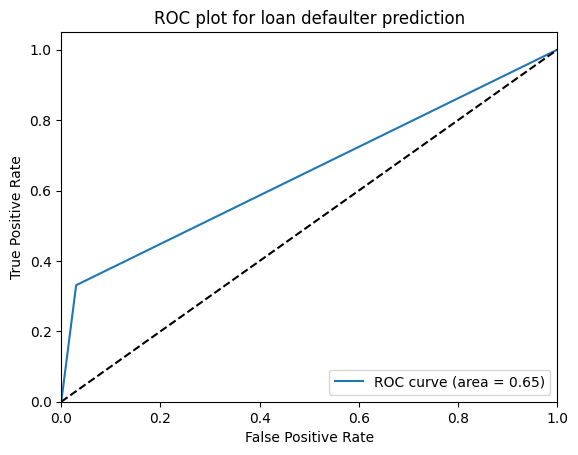

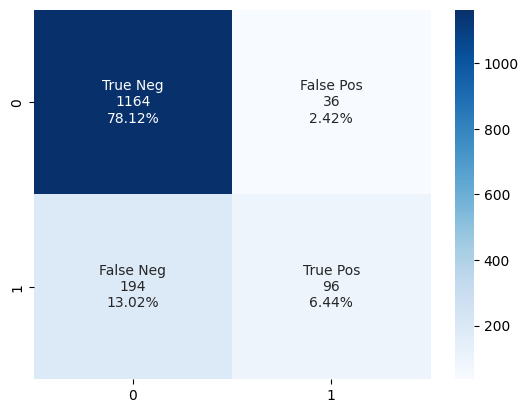



 
 
 

using dataset pruned: Dataset with all modifications
Accuracy on Training Dataset :  0.8400447427293065
Accuracy on CV Dataset :  0.8422818791946308


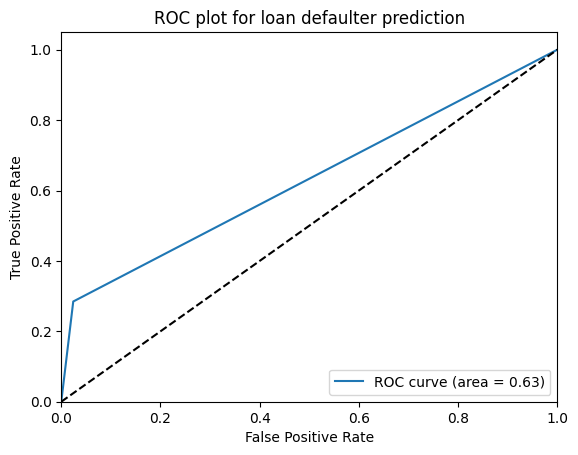

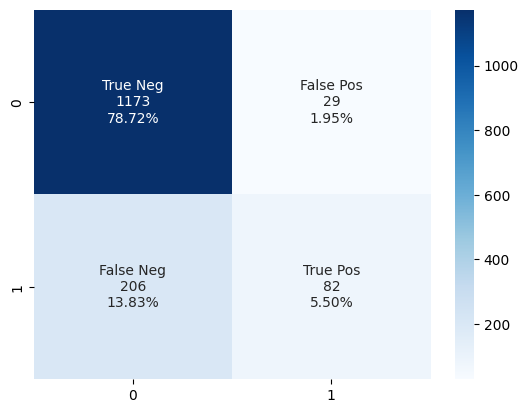



 
 
 

using dataset loan_only: basic but with LOAN transformed
Accuracy on Training Dataset :  0.8442953020134228
Accuracy on CV Dataset :  0.8375838926174497


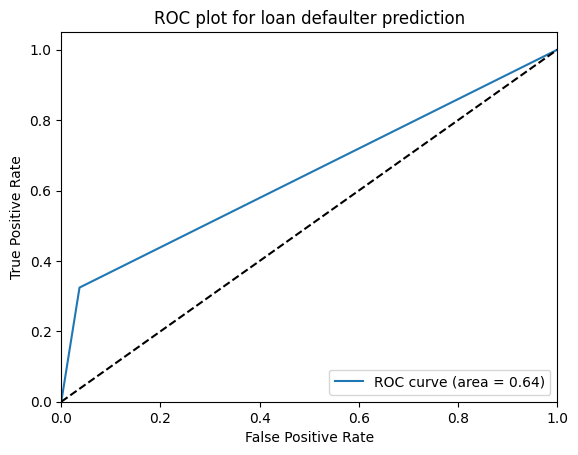

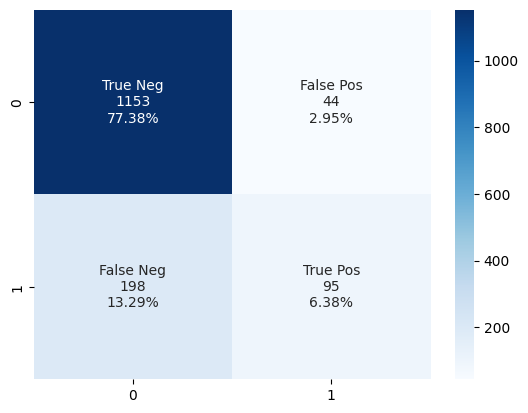



 
 
 

using dataset loan_pp: basic but more than LOAN Transformed
Accuracy on Training Dataset :  0.8451901565995525
Accuracy on CV Dataset :  0.8375838926174497


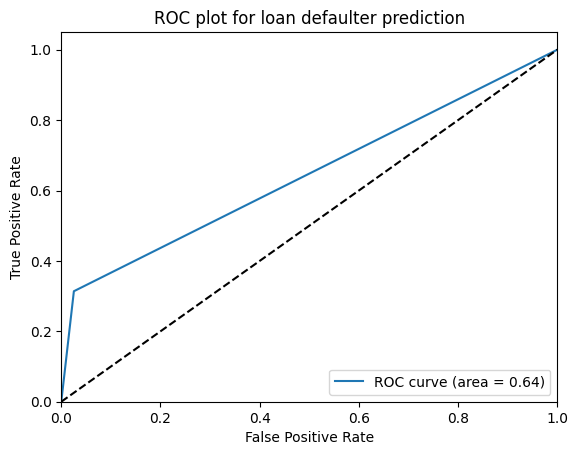

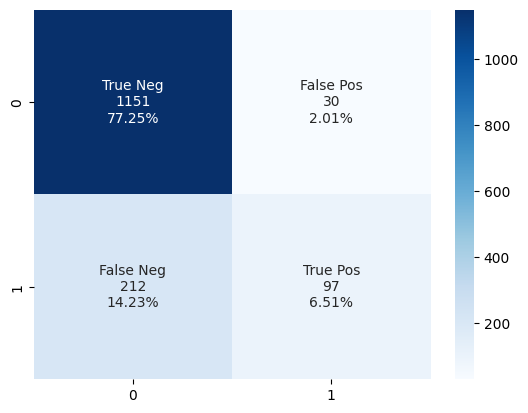

In [ ]:
df_analytics = build_and_analyse([basic,pruned,loan_only,loan_pp],LogisticRegressionCV,10)

We now compare visualisations over various metrics for which dataset logistic regression is best suited for:

In [ ]:
df_analytics_plot = pd.DataFrame(df_analytics)

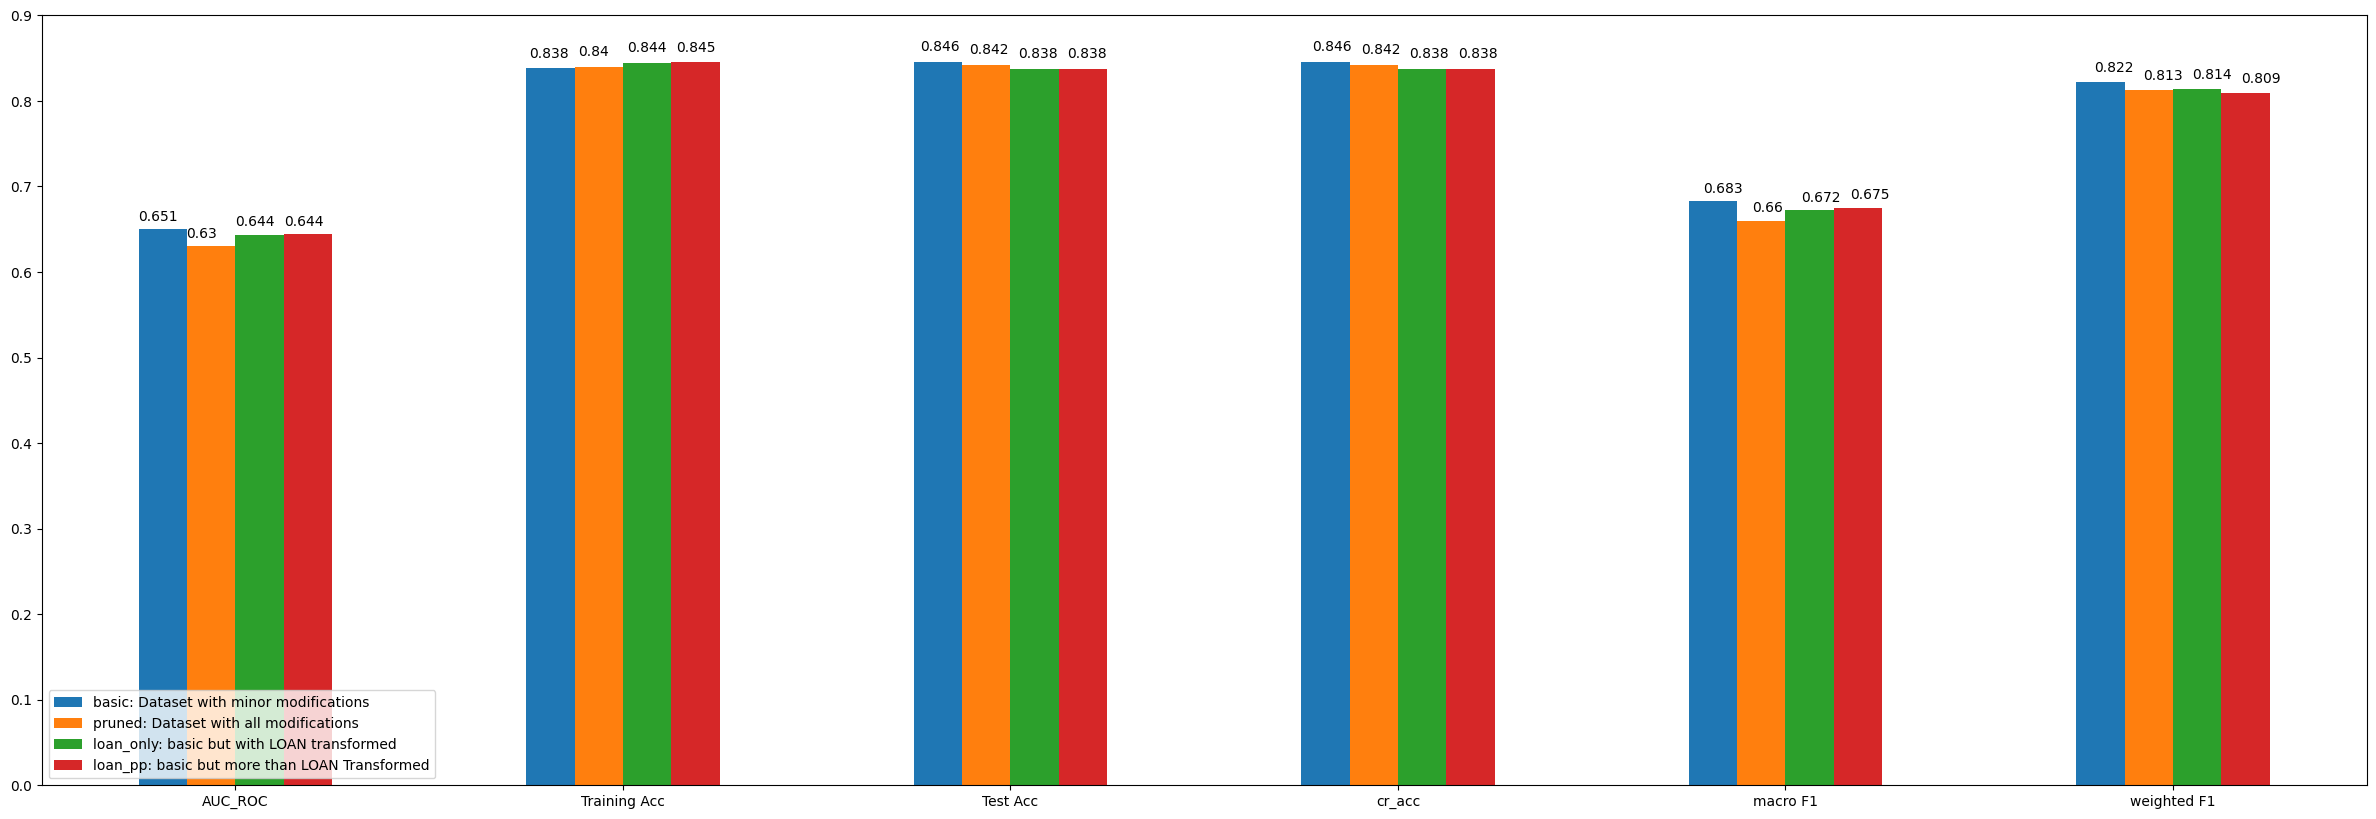

In [ ]:
plottable_cols = list(set(df_analytics_plot.columns) - {'Model'})
# print(plottable_cols)
ax = df_analytics_plot[:-1].plot(kind='bar',figsize = (30,10),rot=0)
ax.set_ylim(0, 0.9)
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),3)), (p.get_x() * 1.010, p.get_height() * 1.015),)
plt.legend(loc='lower left')
plt.show()


Overall for the metrics plotted, it can be observed that the logistic regression model plotted using the dataset 'LOAN_ONLY', where only the loan attribute was transformed, had the best results. across the board, albeit the model having a less than desirable overall performance over the 0.6 - 0.8 range for all its metrics. Regardless, we will proceed with the model trained with the 'LOAN_ONLY' data and use it for our predictions.

In [ ]:
best_model = df_analytics_plot['loan_only: basic but with LOAN transformed']['model']
params = best_model.get_params()
print(params)

{'Cs': 10, 'class_weight': None, 'cv': 10, 'dual': False, 'fit_intercept': True, 'intercept_scaling': np.float64(2.195254015709299), 'l1_ratios': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'refit': True, 'scoring': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0}


In [ ]:
# sample probability prediction for 1 applicant

scaled_features_df,y = preprocess(loan_only)
x_train, x_test, y_train, y_test = train_test_split(scaled_features_df,y)
model = LogisticRegressionCV(Cs = 10, intercept_scaling=params['intercept_scaling'])
distributions = dict(intercept_scaling=uniform(loc=0, scale=4),penalty=['l2'])
clf = RandomizedSearchCV(model, distributions, random_state=0)
search = clf.fit(x_train, y_train)
model = search.best_estimator_
model.fit(x_train,y_train)

LogisticRegressionCV(intercept_scaling=np.float64(2.195254015709299))

In [ ]:
# prompt: get the probability of each label being predicted for the last row of the dataframe loan_only

# Predict probabilities for the last row of the loan_only DataFrame
last_row = scaled_features_df.iloc[[-1]]
probabilities = model.predict_proba(last_row)
print('Given the following applicant details:')
print()
print(loan_only.iloc[-1])
print()
print(f"The probability of this applicant defaulting is {round(float(probabilities[0][1]*100),2)}%.")

Given the following applicant details:

BAD                       0
LOAN              28.492407
MORTDUE             48811.0
VALUE               88934.0
YOJ                    15.0
DEROG                   0.0
DELINQ                  0.0
CLAGE            219.601002
NINQ                    0.0
CLNO                   16.0
DEBTINC           34.571519
Mgr                   False
Office                False
Other                  True
ProfExe               False
Sales                 False
Self                  False
DebtCon                True
HomeImp               False
Other reason          False
PROBINC         1411.884732
Name: 5959, dtype: object

The probability of this applicant defaulting is 2.52%.


However, we note that there are limitations to the existing model due to the following reasons:
- A lack of data will result in the accuracy for our predictions to be very skewed, to the point of being entirely 100 or 0, which should not be the case in general.
- more EDA is required for more varaiables that can make inferring the probabilities of the documents more precise, which explains why in general the probabilities we deal with are very high and are unable to reveal much information (ie results are usually 100% risk or 0% risk)